In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet

In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:
group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna(0).reset_index(drop=1)
    return produced_freq

produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [5]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna(0).reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [6]:
def get_subj_df_cue(subject, sess, subj_table):
    cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [7]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [8]:
cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
unit_cue = cue_unit[cue_unit['Cue'] == "After"]
unit_cue_pos = unit_cue[unit_cue['Cue dir'] == "+"].index
unit_cue_neg = unit_cue[unit_cue['Cue dir'] == "-"].index

unit_speech = cue_unit[[[cue_unit['Speech'] == 'Before'] or [cue_unit['Speech'] == 'After']][0][0]]
unit_speech_pos = unit_speech[unit_speech['Speech dir'] == "+"].index
unit_speech_neg = unit_speech[unit_speech['Speech dir'] == "-"].index


In [9]:
def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

In [10]:
def get_zscore(input_mat):
    rest_mat = input_mat[:, :500]
    input_mat_z = np.zeros(input_mat.shape)
    for item in range(rest_mat.shape[0]):
        rest_mean = rest_mat[item].mean()
        rest_sd = np.nanstd(rest_mat[item])
        input_mat_z[item] = (input_mat[item] - rest_mean)/rest_sd
    return input_mat_z

In [14]:
xvals = np.linspace(-1.5, 3.5, 5000)


In [17]:
def get_avg_activity_cue(number_elec):
    spike_mat_sig = np.zeros((5000))
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    cue_start_all = subj_df_cue['starts_y']
    
    rest_time = find_rest_time(subj_df_cue)
    rest_spike = get_df(rest_time, neural_df, timing, before=0, after=0.75)
    FR_mean = rest_spike.mean()
    FR_std = np.nanstd(rest_spike)
    FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

    spike_mat_1 = get_df(cue_start_1, neural_df, timing, after=3.5, before=1.5)
    spike_mat_1_mean = spike_mat_1.mean(axis=0)
    significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(spike_mat_1, FR_compare).pvalue, 
                                "fval":f_oneway(spike_mat_1, FR_compare).statistic})
    for item in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][item] == True:
            if spike_mat_1_mean[item] > FR_mean:
                spike_mat_sig[item] = 1
            if spike_mat_1_mean[item] < FR_mean:
                spike_mat_sig[item] = -1
    
    return spike_mat_sig, np.array(significance.pval), np.array(significance.fval)

In [21]:
temp1, temp2, temp3 = get_avg_activity_cue(48)

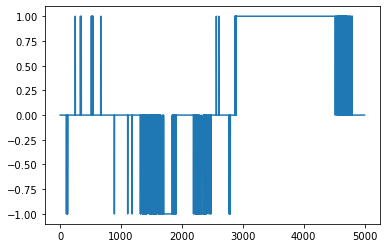

In [22]:
plt.plot(temp1)

In [23]:
spike_mat_sig_all = []
pval_all = []
fval_all = []

for item in cue_unit.index[22:]:
    SUBJECT = info.iloc[item, 0]
    session = info.iloc[item, 1]
    contact = info.iloc[item, 3]
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    if len(timing) != 0:
        print(item)

        spike_mat_sig_elec, pval_elec, fval_elec = get_avg_activity_cue(item)
        spike_mat_sig_all.append(spike_mat_sig_elec)
        pval_all.append(pval_elec)
        fval_all.append(fval_elec)
    
spike_mat_sig_all = np.array(spike_mat_sig_all)
pval_all = np.array(pval_all)
fval_all = np.array(fval_all)


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
182
183
184
185
186
187
188
189
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


In [26]:
all_unit_activity_sig = {'spike_mat_sig_all':spike_mat_sig_all, 
                     'pval_all':pval_all, 
                     'fval_all':fval_all}
savemat("processed_data/all_unit_activity_sig.mat", all_unit_activity_sig)



In [14]:
all_unit_ave_activity = {'cue_mat_1':cue_mat_1, 
                     'cue_mat_all':cue_mat_all, 
                     'cue_mat_1_sem':cue_mat_1_sem, 
                     'cue_mat_all_sem':cue_mat_all_sem}
savemat("processed_data/all_unit_ave_activity.mat", all_unit_ave_activity)



In [ ]:
zscore(cue_mat_1, axis=1)

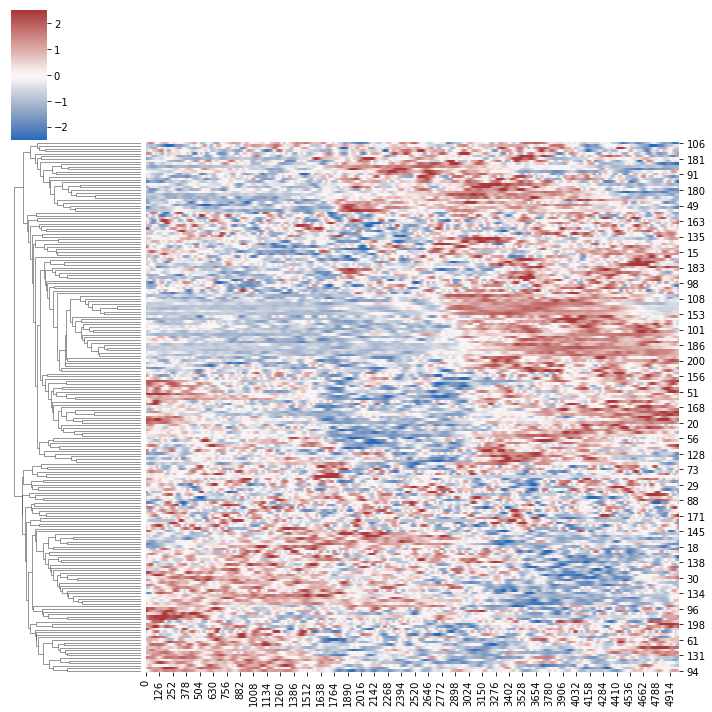

In [16]:
axs = sns.clustermap(zscore(cue_mat_1, axis=1), col_cluster=0, cmap='vlag', vmax=2.5, vmin=-2.5)


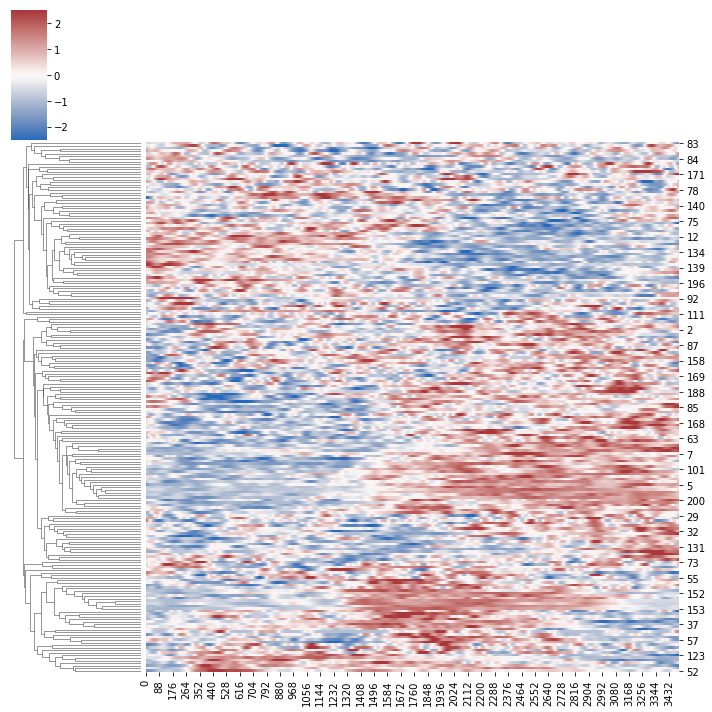

In [18]:
axs = sns.clustermap(zscore(cue_mat_1, axis=1)[:, 1500:], col_cluster=0, cmap='vlag', vmax=2.5, vmin=-2.5)


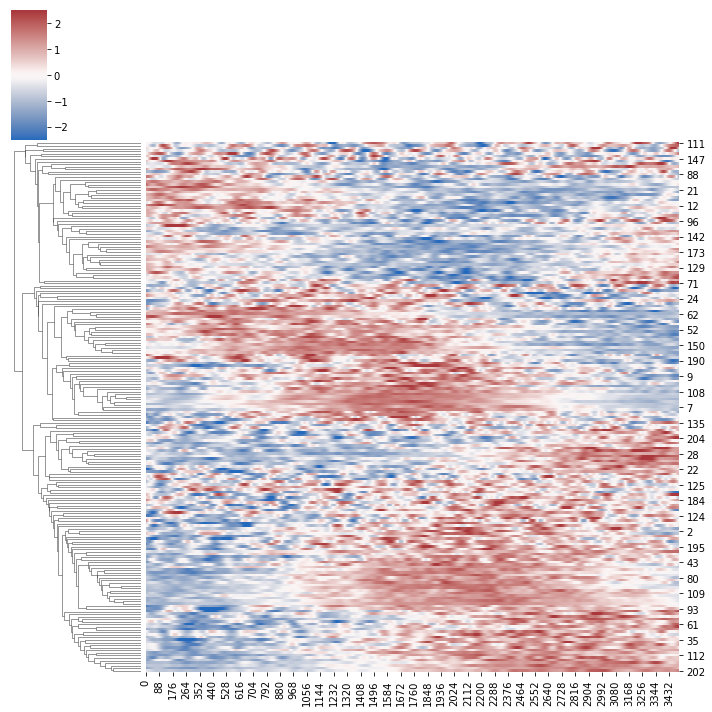

In [20]:
axs = sns.clustermap(zscore(cue_mat_all, axis=1)[:, 1500:], col_cluster=0, cmap='vlag', vmax=2.5, vmin=-2.5)


In [32]:
def zscore_bseline(input_mat):
    use_unit_z = np.zeros(input_mat.shape)
    for item in range(input_mat.shape[0]):
        use_unit = input_mat[item]
        unit_baseline = use_unit[0:1500]
        unit_baseline_mean = np.mean(unit_baseline)
        unit_baseline_std = np.std(unit_baseline)
        use_unit_z[item] = (use_unit - unit_baseline_mean)/unit_baseline_std
    return use_unit_z

In [33]:
zscore_bseline(cue_mat_1).shape

(205, 5000)

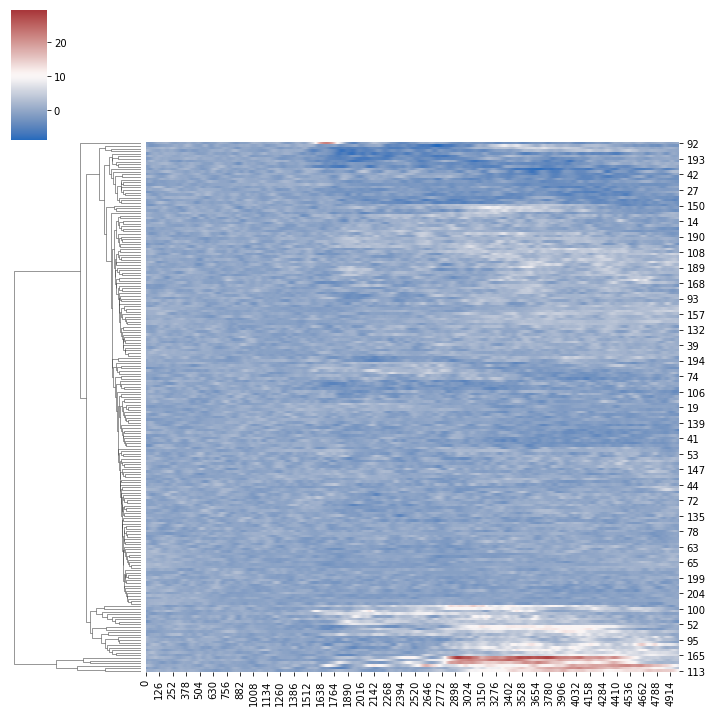

In [35]:
axs = sns.clustermap(zscore_bseline(cue_mat_1), col_cluster=0, cmap='vlag')


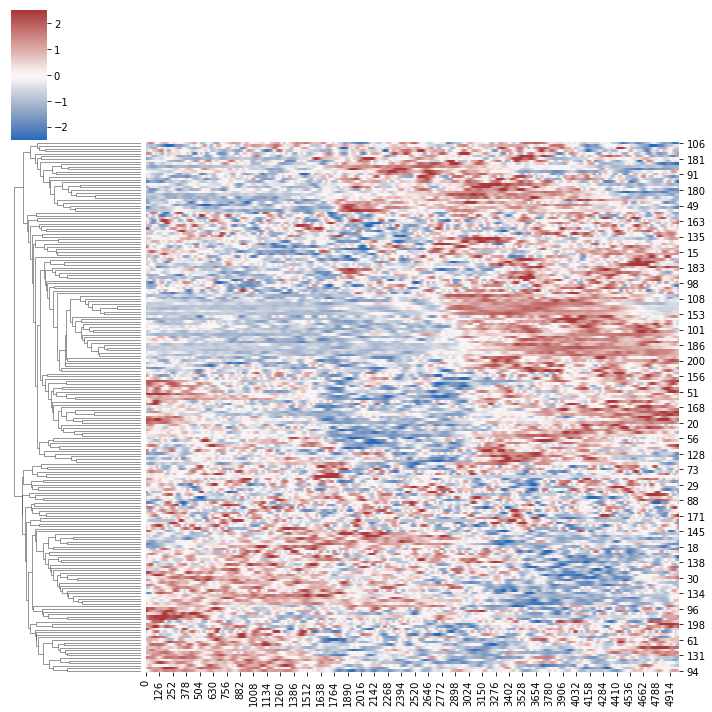

In [38]:
axs = sns.clustermap(zscore(zscore_bseline(cue_mat_1), axis=1), col_cluster=0, cmap='vlag', vmax=2.5, vmin=-2.5)


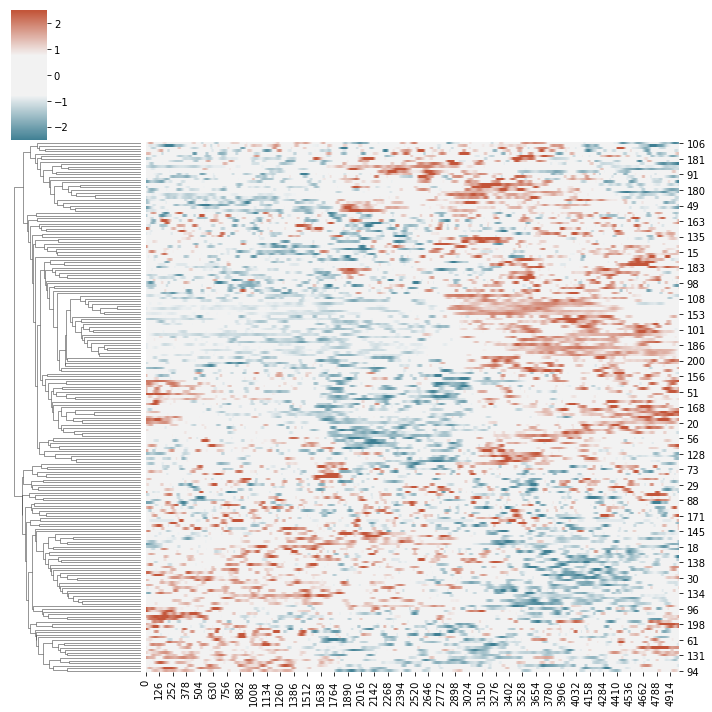

In [49]:
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=80)
axs = sns.clustermap(zscore(zscore_bseline(cue_mat_1), axis=1), col_cluster=0, 
                     cmap=use_cmap, vmax=2.5, vmin=-2.5)


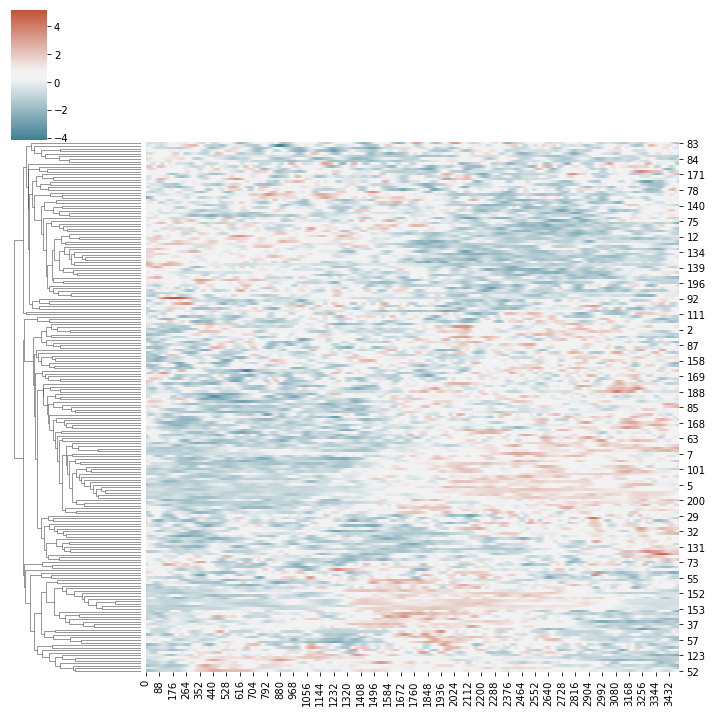

In [52]:
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=20)
axs = sns.clustermap(zscore(zscore_bseline(cue_mat_1), axis=1)[:, 1500:], col_cluster=0, 
                     cmap=use_cmap)


In [53]:
import scipy.cluster.hierarchy as hac 


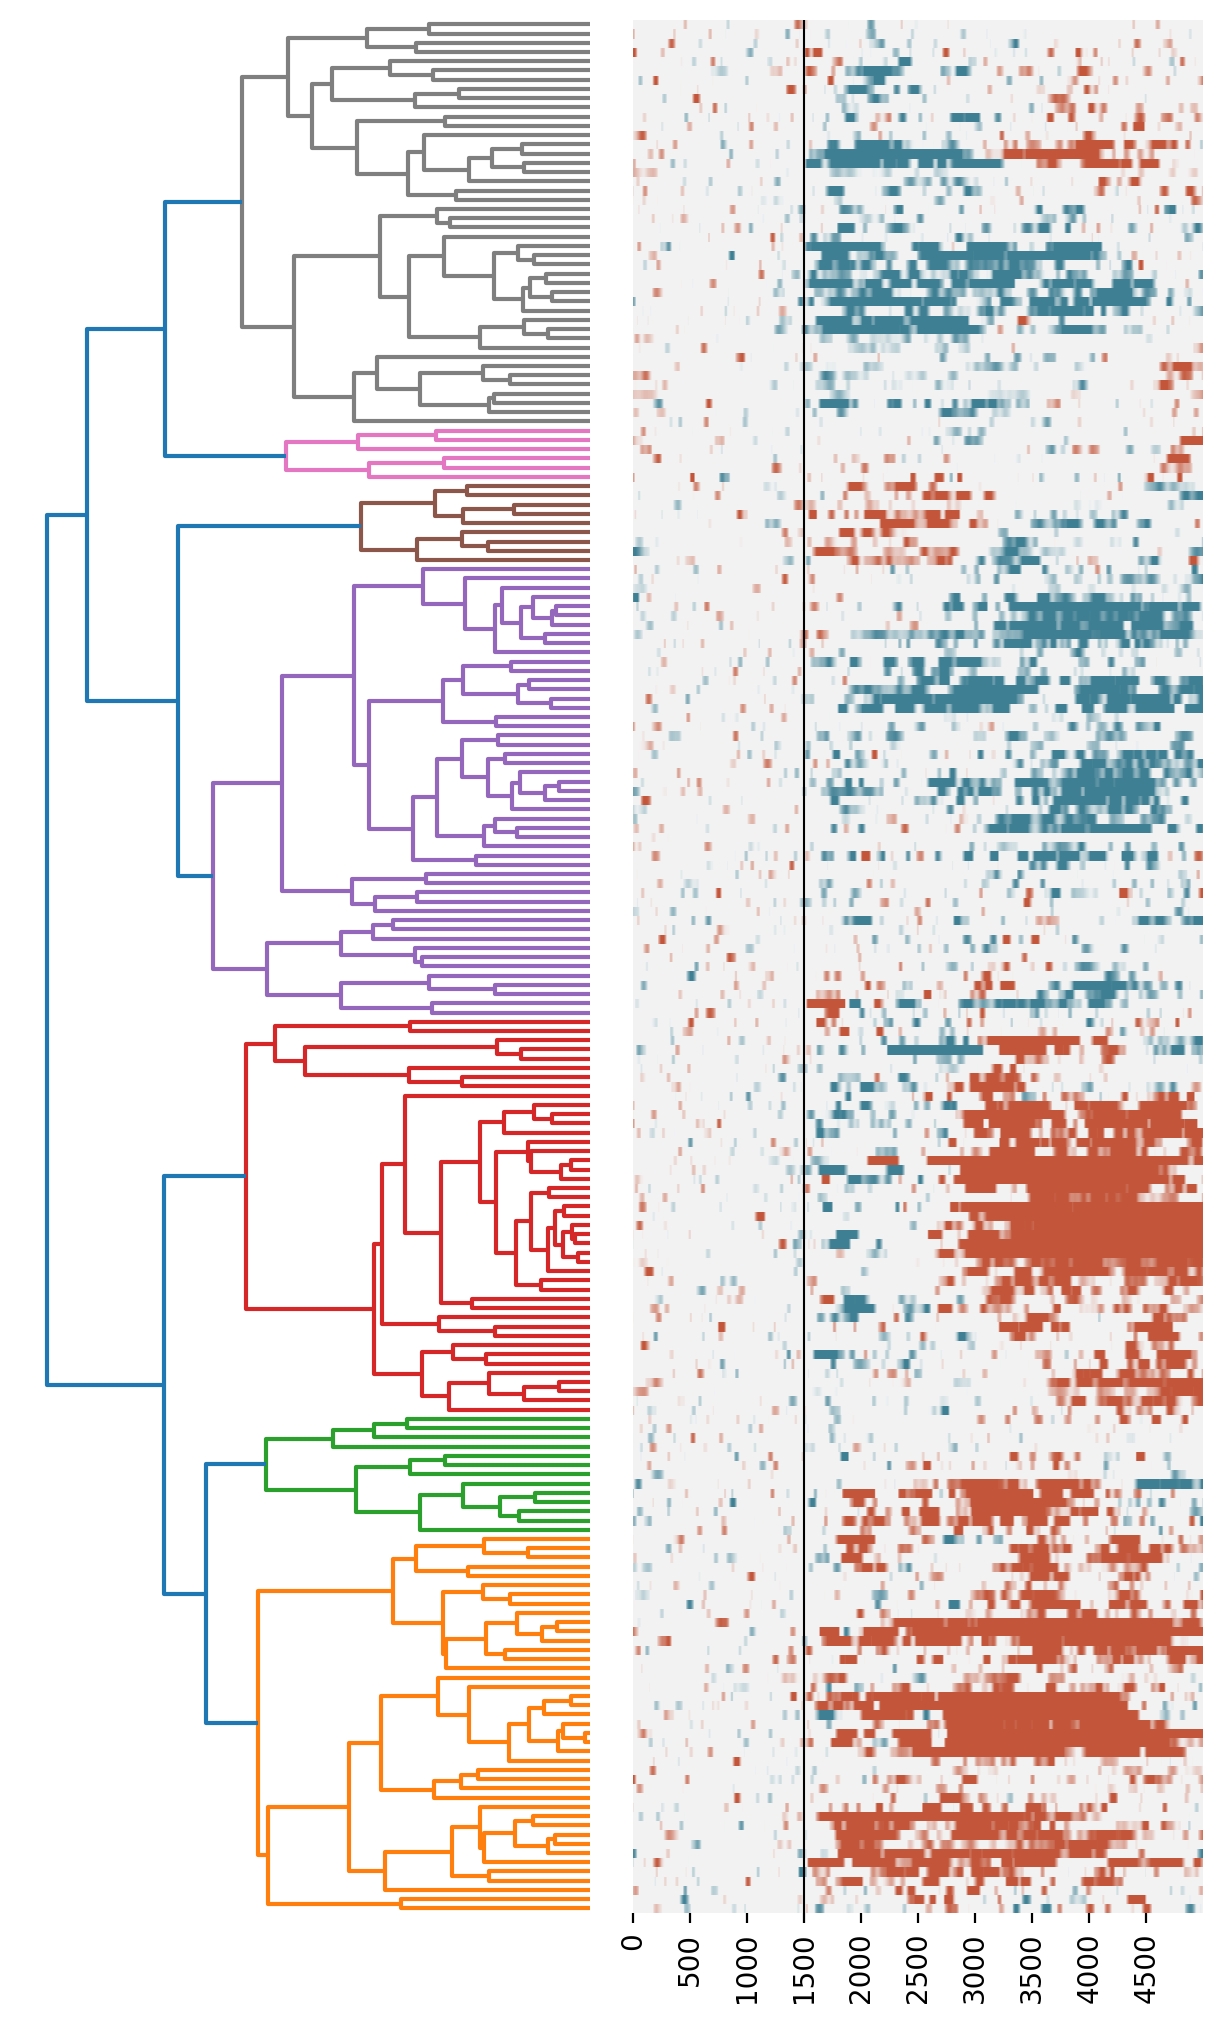

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(6, 10), dpi=200, constrained_layout=True)
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=125)

Z = hac.linkage(zscore_bseline(cue_mat_1)[:, 1500:], 
                metric='cosine', optimal_ordering=1, method='complete')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(cue_mat_1.shape)
for item in range(cue_mat_1.shape[0]):
    cos_ordered_units[item] = cue_mat_1[dn['leaves'][item]]
    
sns.heatmap(zscore_bseline(cos_ordered_units), cmap=use_cmap, cbar=False, 
            vmax=3, vmin=-3, ax=axs[1], yticklabels=False, xticklabels=500)
axs[1].invert_yaxis()
axs[0].axis('off')
axs[1].axvline(1500, color='k', linewidth=0.75)
plt.show();

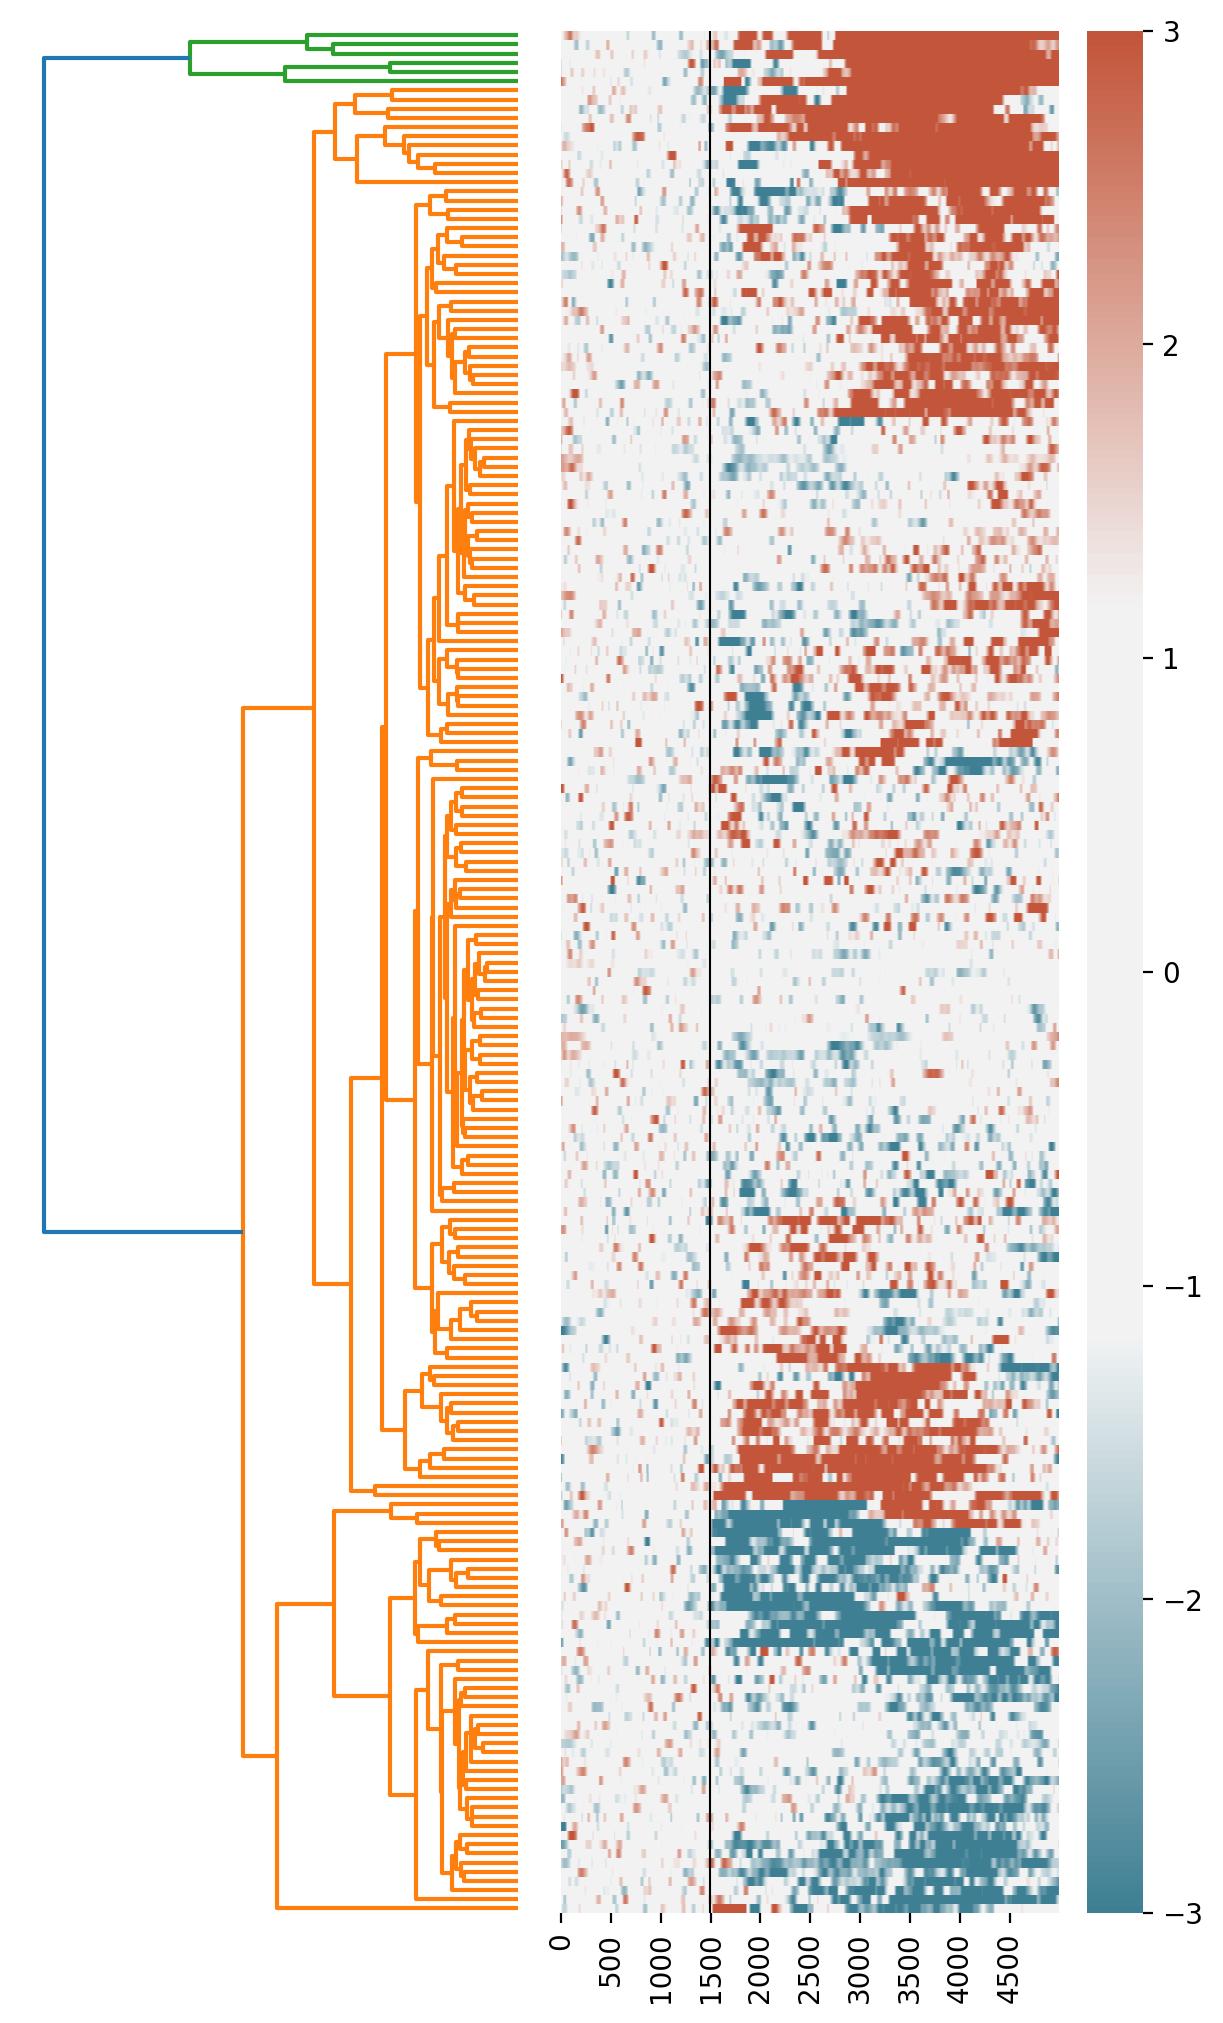

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(6, 10), dpi=200, constrained_layout=True)
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=100)

Z = hac.linkage(zscore_bseline(cue_mat_1)[:, 1500:], 
                metric='euclidean', optimal_ordering=1, method='weighted')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(cue_mat_1.shape)
for item in range(cue_mat_1.shape[0]):
    cos_ordered_units[item] = cue_mat_1[dn['leaves'][item]]
    
sns.heatmap(zscore_bseline(cos_ordered_units), cmap=use_cmap, 
            vmax=3, vmin=-3, ax=axs[1], yticklabels=False, xticklabels=500)
axs[1].invert_yaxis()
axs[0].axis('off')
axs[1].axvline(1500, color='k', linewidth=0.75)
plt.show();

In [168]:
scipy.signal.resample(zscore_bseline(cos_ordered_units), 500, axis=1).shape

(205, 500)

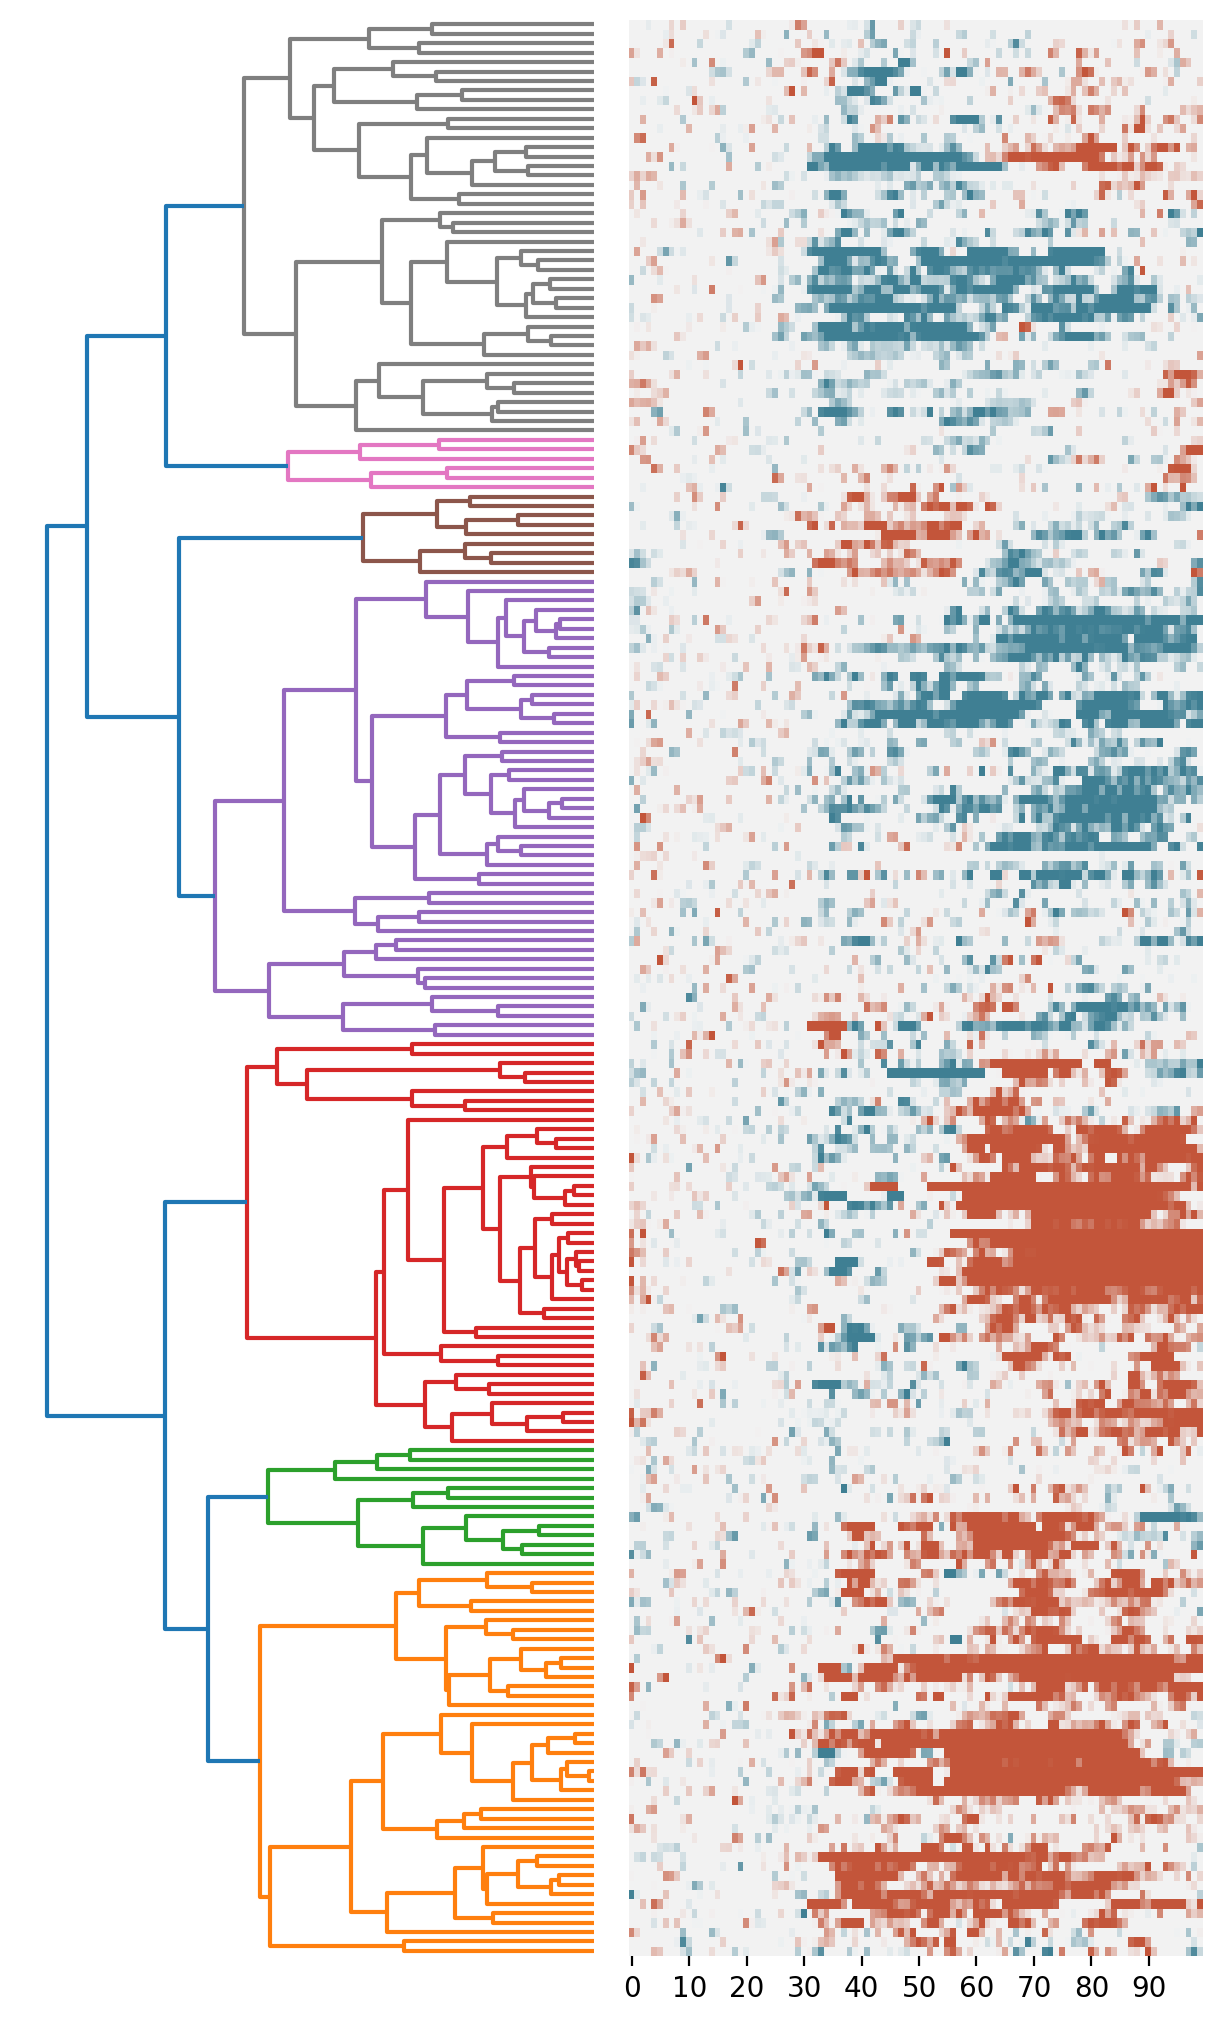

In [175]:
fig, axs = plt.subplots(1, 2, figsize=(6, 10), dpi=200, constrained_layout=True)
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=100)

Z = hac.linkage(zscore_bseline(cue_mat_1)[:, 1500:], 
                metric='cosine', optimal_ordering=1, method='complete')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(cue_mat_1.shape)
for item in range(cue_mat_1.shape[0]):
    cos_ordered_units[item] = cue_mat_1[dn['leaves'][item]]
    
sns.heatmap(scipy.signal.resample(zscore_bseline(cos_ordered_units), 100, axis=1), cmap=use_cmap, 
            vmax=3, vmin=-3, ax=axs[1], yticklabels=False, xticklabels=10, cbar=False)
axs[1].invert_yaxis()
axs[0].axis('off')
axs[1].axvline(1500, color='k', linewidth=0.75)
plt.show();

In [62]:
np.flipud(zscore_bseline(cos_ordered_units))

array([[-0.80205336, -0.79785769, -0.79367858, ..., -0.34298728,
        -0.30217095, -0.26217483],
       [-0.80634272, -0.85704003, -0.90622039, ...,  0.95666316,
         0.97819828,  0.99884292],
       [-0.0375885 , -0.05867188, -0.07863098, ...,  1.00077799,
         1.03287604,  1.06395396],
       ...,
       [-0.803751  , -0.80467622, -0.80569773, ..., -0.63161781,
        -0.64013801, -0.64841937],
       [ 0.03082757,  0.02642313,  0.02254498, ..., -1.32501464,
        -1.29848785, -1.27054043],
       [ 0.59451097,  0.61704575,  0.63970774, ...,  0.69050989,
         0.72693519,  0.76344222]])